# Country-level factors dynamics and ABO/Rh blood groups contribution to COVID-19 mortality
## Loading data and defining variables

In [1]:
library(readxl)
library(corrplot)
library(randomForest)
library(Boruta)
library(Metrics)
library(tidyverse)
library(caret)

RMSE = function(m, o){
  sqrt(mean(((m - o))^2))
}
RSQ = function(x, y){
  100*cor(x, y)^2
}
MAE = function(m, o){
   mean(abs(m - o)) 
}

corrplot 0.90 loaded

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()  masks randomForest::combine()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ ggplot2::margin() masks randomForest::margin()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following objects are masked from ‘package:Metrics’:

    precision, recall




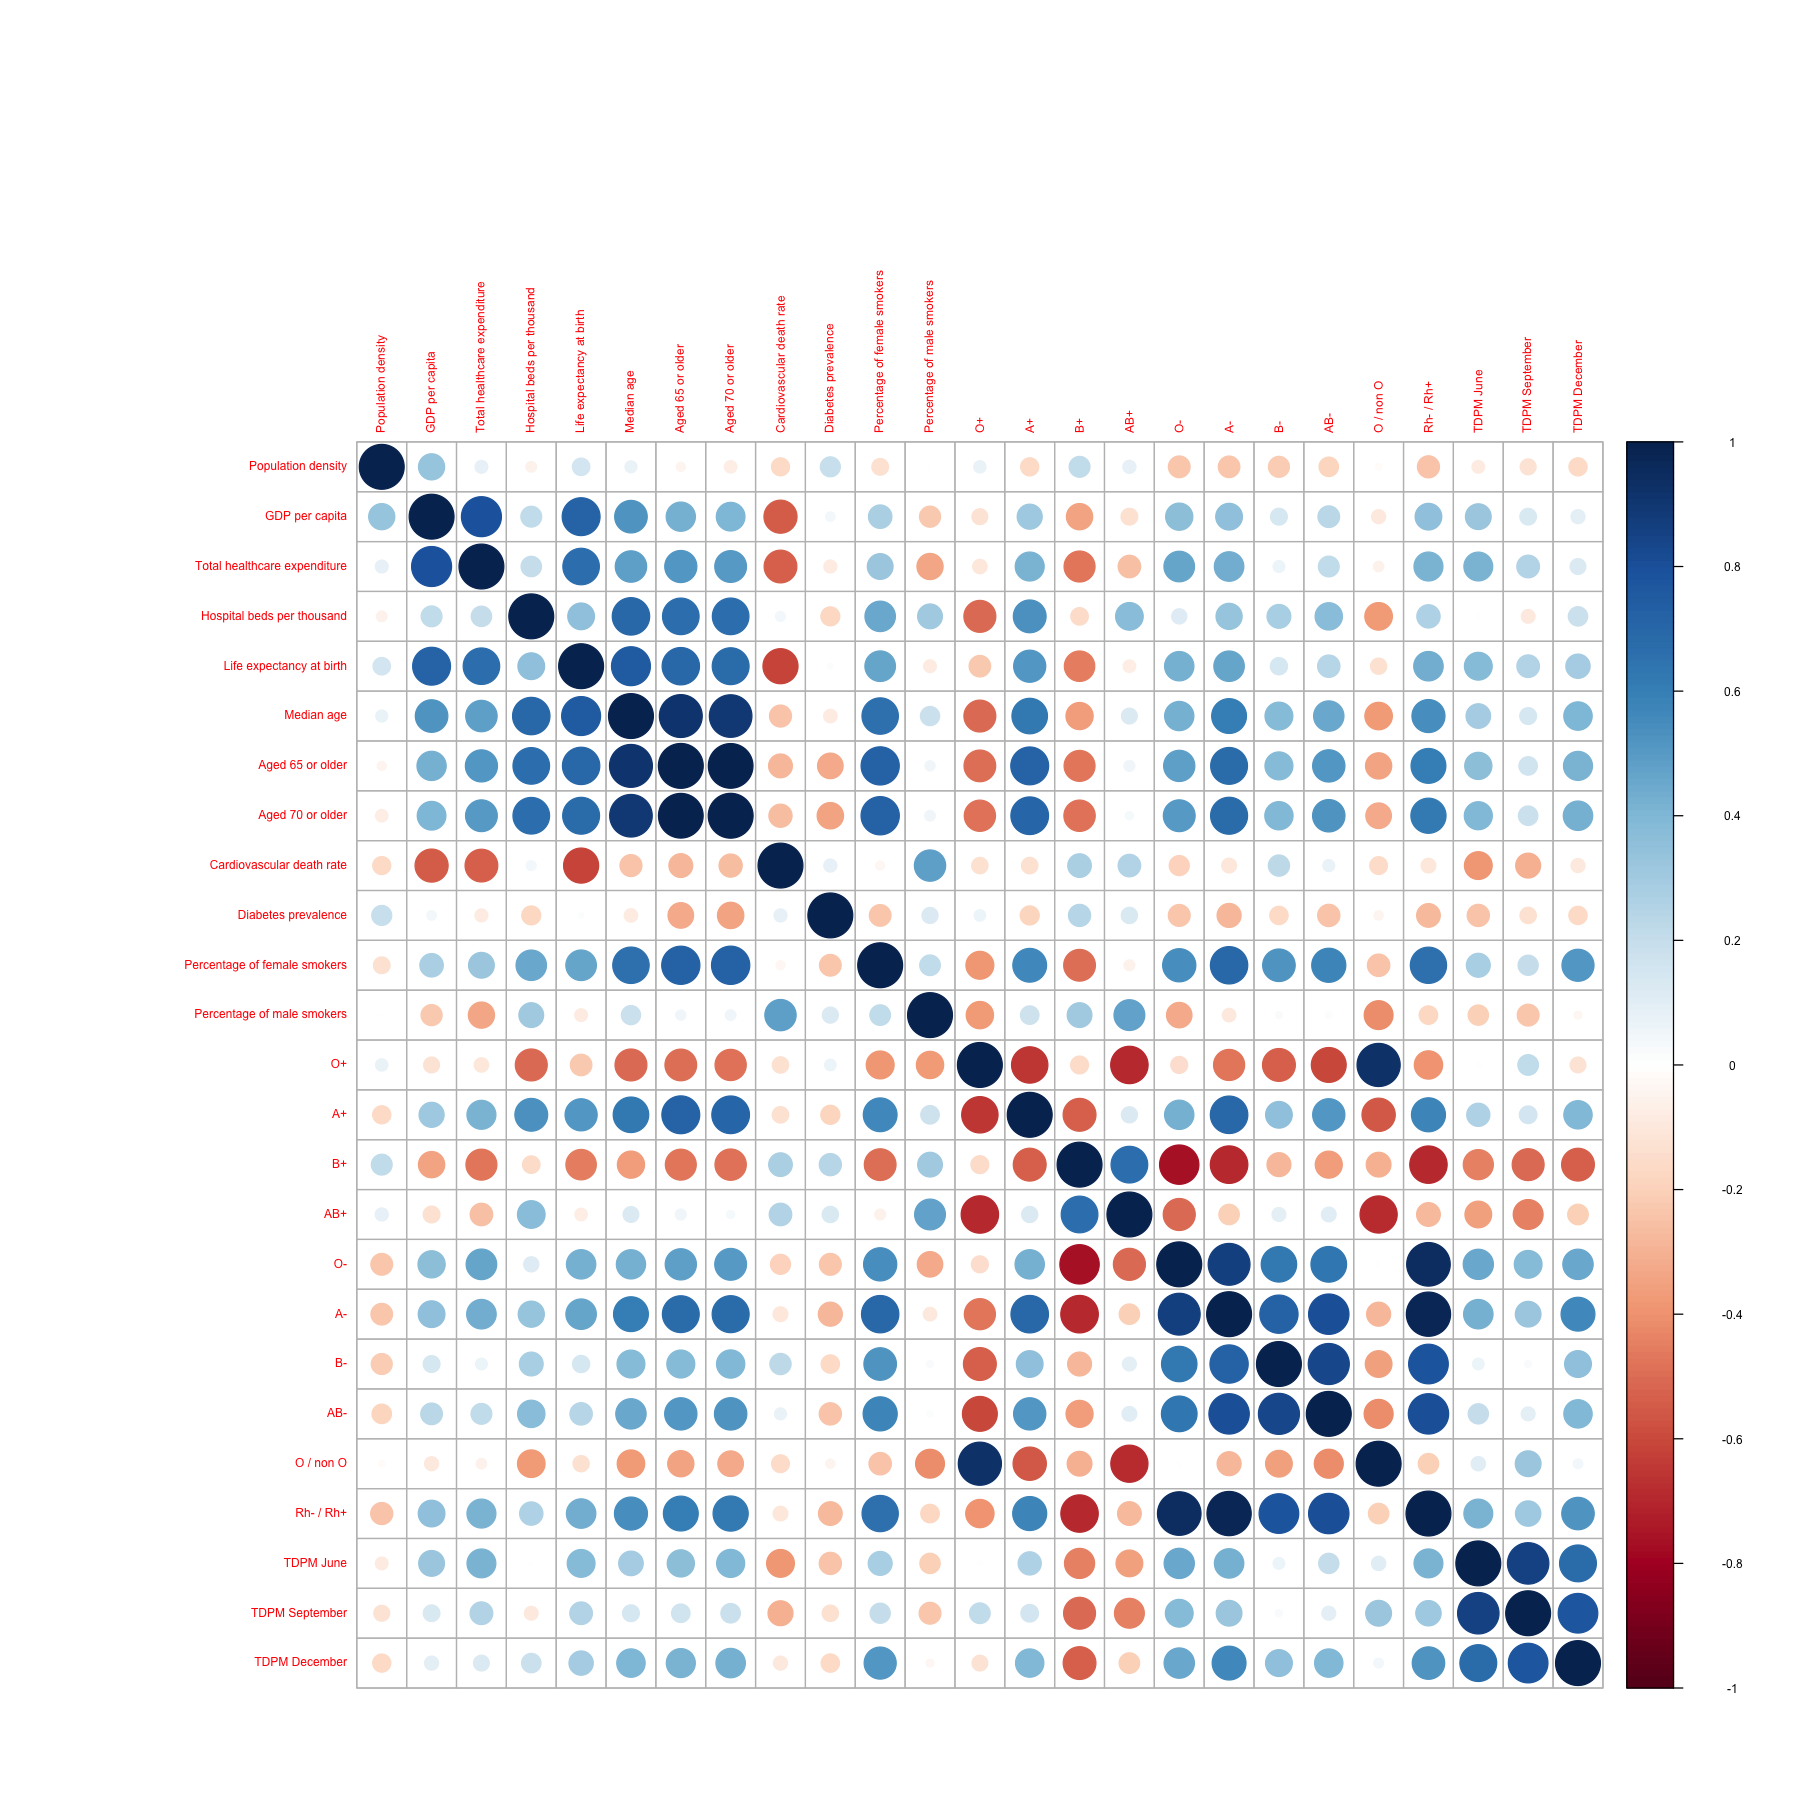

In [2]:
#FIGURE 2 AND MODEL DEFINITION
data <- read_excel("tabella_dati_all.xlsx")

#define model and sort variables for figure 2
Xmodel = paste(colnames(data[, c(6, 3, 5, 12, 4, 7:11, 13, 14, 18:27)]), collapse = "+")
Xindex = c(6, 3, 5, 12, 4, 7:11, 13, 14, 18:27)
Xdata = data[, Xindex]
columnsPlot = c(6, 3, 5, 12, 4, 7:11, 13, 14, 18:27, 16, 17, 15)
Xplot = data[, columnsPlot]

#rename columns for readability
full_labels <- c("Population density", "GDP per capita", "Total healthcare expenditure", "Hospital beds per thousand",
"Life expectancy at birth", "Median age", "Aged 65 or older", "Aged 70 or older", "Cardiovascular death rate", "Diabetes prevalence",
"Percentage of female smokers", "Percentage of male smokers", "O+", "A+", "B+", "AB+", "O-", "A-", "B-", "AB-", "O / non O", "Rh- / Rh+", 
"TDPM June", "TDPM September", "TDPM December")
colnames(Xplot) <- full_labels

#setEPS()
#postscript("Correlation.eps", width=6.0, height=6.0)
options(repr.plot.width = 15, repr.plot.height = 15)
corrplot(cor(Xplot), method = "circle", tl.cex = 0.6, cl.cex = 0.6)
#dev.off()

## Regression with RF Boruta repeated 100 times
## Saving importance values 
### December

In [3]:
#NEEDED TO PRODUCE FIGS 4 AND 5
formula <- formula(paste("TDPM_12~", Xmodel, collapse = ""))
importance12 <- c()
for (s in sample(0:500, 500, replace = FALSE)){
    set.seed(s)
    boruta <- Boruta(formula, data = data, doTrace = 0, maxRuns = 100)
    importance12 <- cbind(importance12, boruta$ImpHistory[99, ])
}
importanceMean12 = rowMeans(importance12)
importanceSD12 = apply(importance12, 1, sd, na.rm = TRUE)

In [4]:
#TABLE III column 5
formula <- formula(paste("TDPM_12~", Xmodel, collapse = ""))
selected <- c()
for (s in 1:100){
    set.seed(s)
    boruta <- Boruta(formula, data = data, doTrace = 0, maxRuns = 100)
    selected <- c(selected, getSelectedAttributes(boruta, withTentative = F))
}
table(selected)

selected
        Aminus          Aplus         Bminus          Bplus         Ominus 
           100              1             76            100            100 
Rhminus_Rhplus    density_pop female_smokers 
           100            100            100 

In [5]:
#NEEDED TO PRODUCE FIGS 4 AND 5
all_rmse = c()
all_rsq = c()
sd = signif(sd(data$TDPM_12), digits = 3)
importance12RF = c()
for (s in sample(1:100, 100, replace = FALSE)){
    set.seed(s)
    rf_classifier = randomForest(TDPM_12 ~ Bplus + Ominus + Aminus + Rhminus_Rhplus + female_smokers + density_pop, 
                                 data = data, ntree = 500, mtry = 2, importance = TRUE)
    rmse = sqrt(rf_classifier$mse[length(rf_classifier$mse)])
    rsq = 100*rf_classifier$rsq[length(rf_classifier$rsq)]
    all_rmse = c(all_rmse, rmse)
    all_rsq = c(all_rsq, rsq)
    importance = importance(rf_classifier)[, 1]
    importance12RF <- cbind(importance12RF, importance)
}

## September

In [6]:
#NEEDED TO PRODUCE FIGS 4 AND 5
formula <- formula(paste("TDPM_09~", Xmodel, collapse = ""))
importance09 <- c()
for (s in sample(0:500, 500, replace = FALSE)){
    set.seed(s)
    boruta <- Boruta(formula, data = data, doTrace = 0, maxRuns = 100)
    importance09 <- cbind(importance09, boruta$ImpHistory[99, ])
}
importanceMean09 = rowMeans(importance09)
importanceSD09 = apply(importance09, 1, sd, na.rm = TRUE)

In [7]:
#TABLE III column 4
formula <- formula(paste("TDPM_09~", Xmodel, collapse = ""))
selected <- c()
for (s in 1:100){
    set.seed(s)
    boruta <- Boruta(formula, data = data, doTrace = 0, maxRuns = 100)
    selected <- c(selected, getSelectedAttributes(boruta, withTentative = F))
}
table(selected)

selected
               Abplus                Aminus                 Bplus 
                  100                    49                   100 
               Ominus                 Oplus        Rhminus_Rhplus 
                    4                     2                     1 
cardiovasc_death_rate 
                   20 

In [8]:
#NEEDED TO PRODUCE FIGS 4 AND 5
all_rmse = c()
all_rsq = c()
sd=signif(sd(data$TDPM_09), digits = 3)
importance09RF = c()
for (s in sample(1:100, 100, replace = FALSE)){
    set.seed(s)
    rf_classifier = randomForest(TDPM_09 ~ Bplus + Abplus, data = data, ntree = 500, mtry = 2, importance = TRUE)
    rmse = sqrt(rf_classifier$mse[length(rf_classifier$mse)])
    rsq = 100 * rf_classifier$rsq[length(rf_classifier$rsq)]
    all_rmse = c(all_rmse, rmse)
    all_rsq = c(all_rsq, rsq)
    importance = importance(rf_classifier)[, 1]
    importance09RF <- cbind(importance09RF, importance)
}

## June

In [9]:
#NEEDED TO PRODUCE FIGS 4 AND 5
formula <- formula(paste("TDPM_06~", Xmodel, collapse = ""))
importance06 <- c()
for (s in sample(0:500, 500, replace = FALSE)){
    set.seed(s)
    boruta <- Boruta(formula, data = data, doTrace = 0, maxRuns = 100)
    importance06 <- cbind(importance06, boruta$ImpHistory[99,])
}
importanceMean06 = rowMeans(importance06)
importanceSD06 = apply(importance06, 1, sd, na.rm = TRUE)

In [10]:
#TABLE III column 3
formula <- formula(paste("TDPM_06~", Xmodel, collapse = ""))
selected <- c()
for (s in 1:100){
    set.seed(s)
    boruta <- Boruta(formula, data = data, doTrace = 0, maxRuns = 100)
    selected <- c(selected, getSelectedAttributes(boruta, withTentative = F))
}
table(selected)

selected
               Abplus                Aminus                 Bplus 
                   91                    25                   100 
               Ominus        Rhminus_Rhplus cardiovasc_death_rate 
                   93                    41                    98 
  diabetes_prevalence  total_hc_expenditure 
                  100                     4 

In [11]:
#NEEDED TO PRODUCE FIGS 4 AND 5
all_rmse = c()
all_rsq = c()
sd = signif(sd(data$TDPM_06), digits = 3)
importance06RF = c()
for (s in sample(0:100, 100, replace = FALSE)){
    set.seed(s)
    rf_classifier = randomForest(TDPM_06 ~ Bplus + cardiovasc_death_rate + diabetes_prevalence, 
                                 data = data, ntree = 500, mtry = 2, importance = TRUE)
    rmse = sqrt(rf_classifier$mse[length(rf_classifier$mse)])
    rsq = 100 * rf_classifier$rsq[length(rf_classifier$rsq)]
    all_rmse = c(all_rmse, rmse)
    all_rsq = c(all_rsq, rsq)
    importance = importance(rf_classifier)[, 1]
    importance06RF <- cbind(importance06RF, importance)
}

Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (-Inf) in boxplot 1 is not drawn”


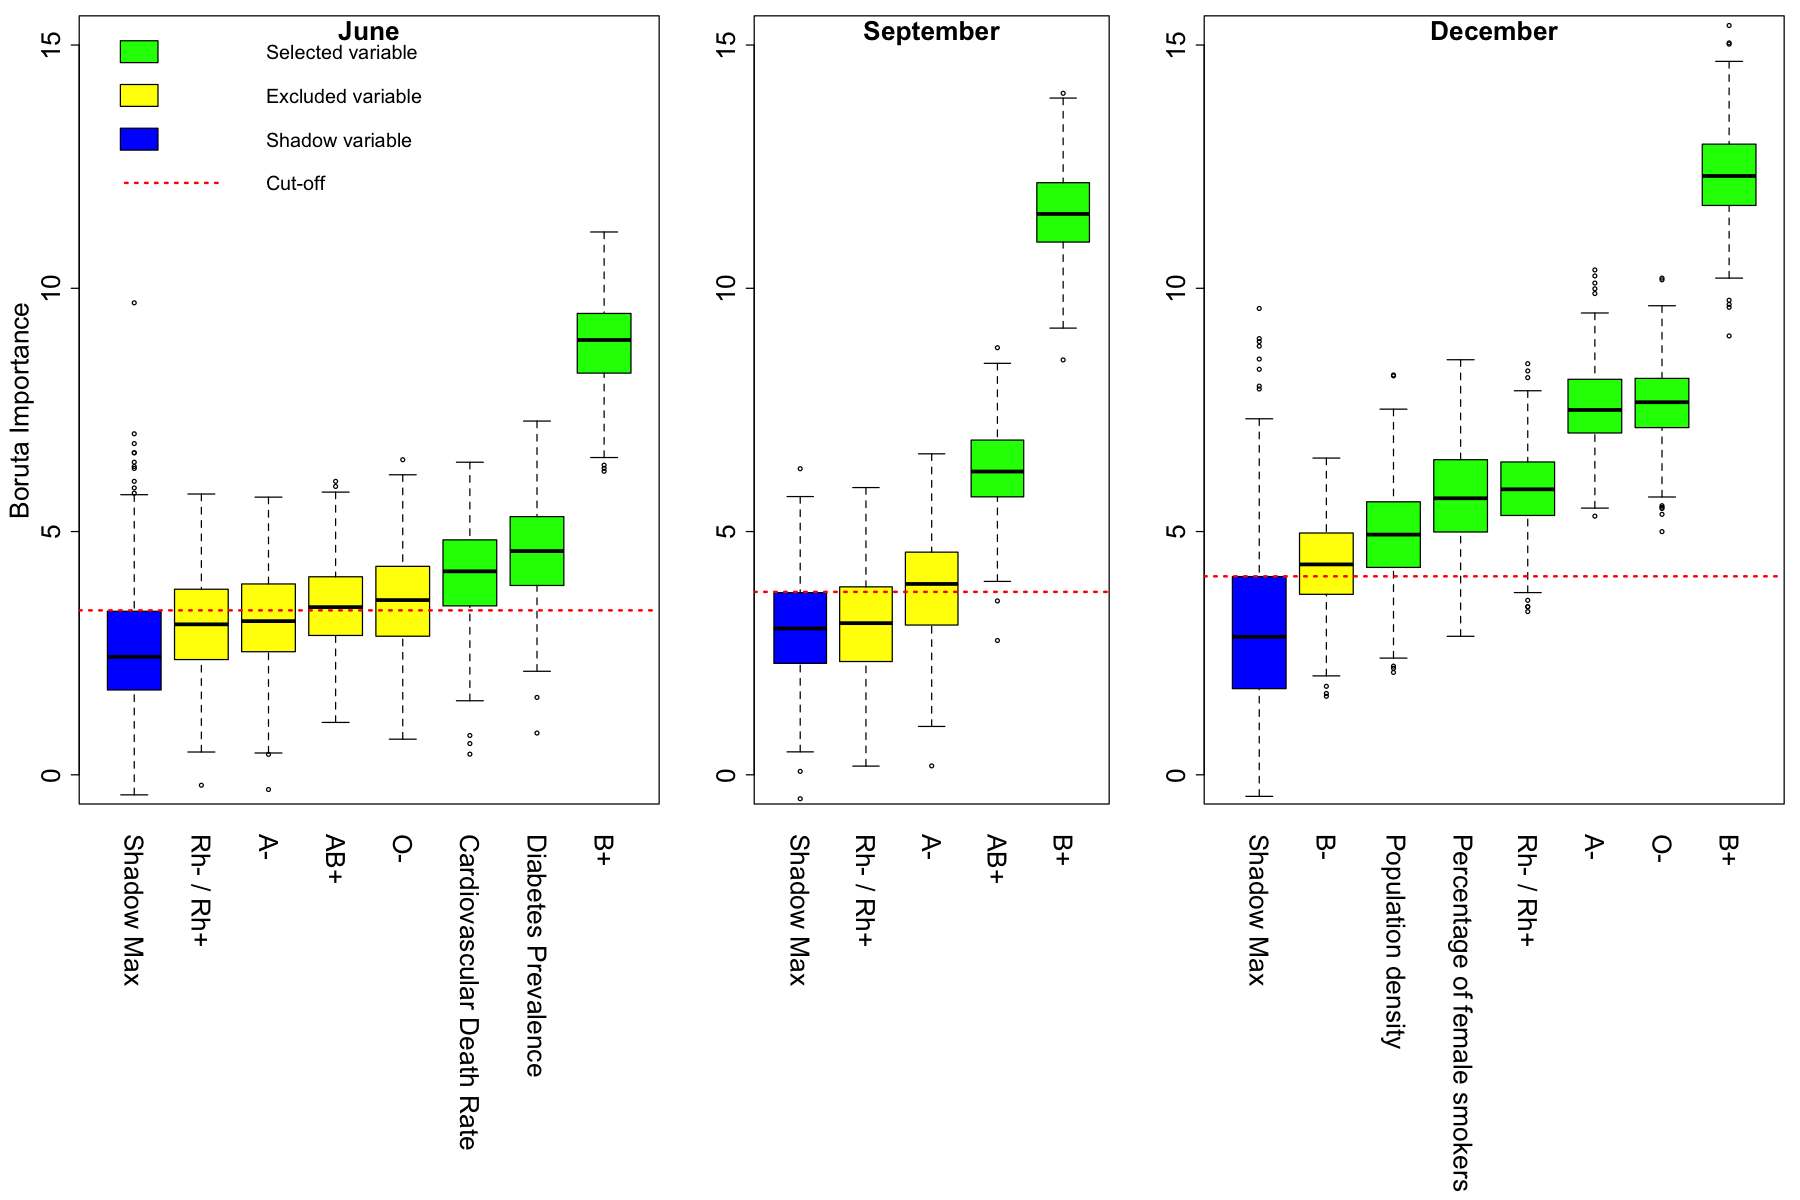

In [12]:
#FIGURE 4
#setEPS()
#postscript("Boruta500.eps", width=15, height=10)

options(repr.plot.width=15, repr.plot.height=10)
layout(matrix(c(1,1,1,2,2,3,3,3), 1, 8, byrow = TRUE))
par(mar=c(25, 5, 1, 1))

#JUNE
names <- c("Shadow Max", "Rh- / Rh+", "A-", "AB+", "O-", "Cardiovascular Death Rate", "Diabetes Prevalence", "B+")

importanceMedian06 = apply(importance06, 1, median, na.rm = TRUE)
o <- order(importanceMean06, decreasing=FALSE)
#names <- c("Shadow Max", "B+")
boxplot(t(importance06[o,][18:25,]), ylim = c(0,15), col = c("blue", rep("yellow", 4), rep("green", 3)), 
        ylab = "Boruta Importance", xlab = "", xaxt = "n", cex.axis = 2, cex.lab = 2)
abline(h = 3.38, col = "red", lty = "dotted", lwd = 2)

title("June", line = -1.5, cex.main = 2)
text(x = 1:8, y = -1.2, labels = names, srt = -90, xpd = NA, cex = 2, adj = 0)
legend("topleft", legend = c("Selected variable", "Excluded variable", "Shadow variable", "Cut-off"), 
       lty = c(0, 0, 0, 3), lwd = c(0, 0, 0, 2), pt.lwd = 0, y.intersp = 1,
  border = c(rep("black", 3), NA), col = c(NA, NA, NA, "red"), text.width = 1, 
       fill = c("green", "yellow", "blue", NA), box.lty = 0, pch = 0, pt.cex = 0.0001, cex = 1.5, 
       horiz = FALSE, inset = c(-0.01, -0.01))

#SEPTEMBER
importanceMedian09 = apply(importance09, 1, median, na.rm = TRUE)
o <- order(importanceMedian09, decreasing=FALSE)
names <- c("Shadow Max", "Rh- / Rh+", "A-", "AB+", "B+")

boxplot(t(importance09[o, ][21:25, ]), ylim = c(0, 15), ylab = "", xlab = "", xaxt = "n", 
        col = c("blue", rep("yellow", 2), rep("green", 2)), cex.axis = 2, cex.lab = 2)
abline(h = 3.76, col = "red", lty = "dotted", lwd = 2)

title("September", line = -1.5, cex.main = 2)
text(x = 1:5, y = -1.2, labels = names, srt = -90, xpd = NA, cex = 2, adj = 0)

#DECEMBER
importanceMedian12 = apply(importance12, 1, median, na.rm = TRUE)
o <- order(importanceMedian12, decreasing=FALSE)
boxplot(t(importance12[o, ][18:25, ]), ylim = c(0,15), ylab = "", xlab = "", xaxt = "n", 
        col = c("blue", "yellow", rep("green", 6)), cex.axis = 2, cex.lab = 2)
abline(h = 4.08, col = "red", lty = "dotted", lwd = 2)

names <- c("Shadow Max", "B-", "Population density", "Percentage of female smokers", "Rh- / Rh+", "A-", "O-", "B+")

text(x = 1:8, y = -1.2, labels = names, srt = -90, xpd = NA, cex = 2, adj = 0)
title("December", line = -1.5, cex.main = 2)
#dev.off()

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"add" is not a graphical parameter”
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"add" is not a graphical parameter”
Warning message in arrows(x, ymin, x, ymax, code = 3, angle = 90, length = 0.1, :
“"add" is not a graphical parameter”
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"add" is not a graphical parameter”


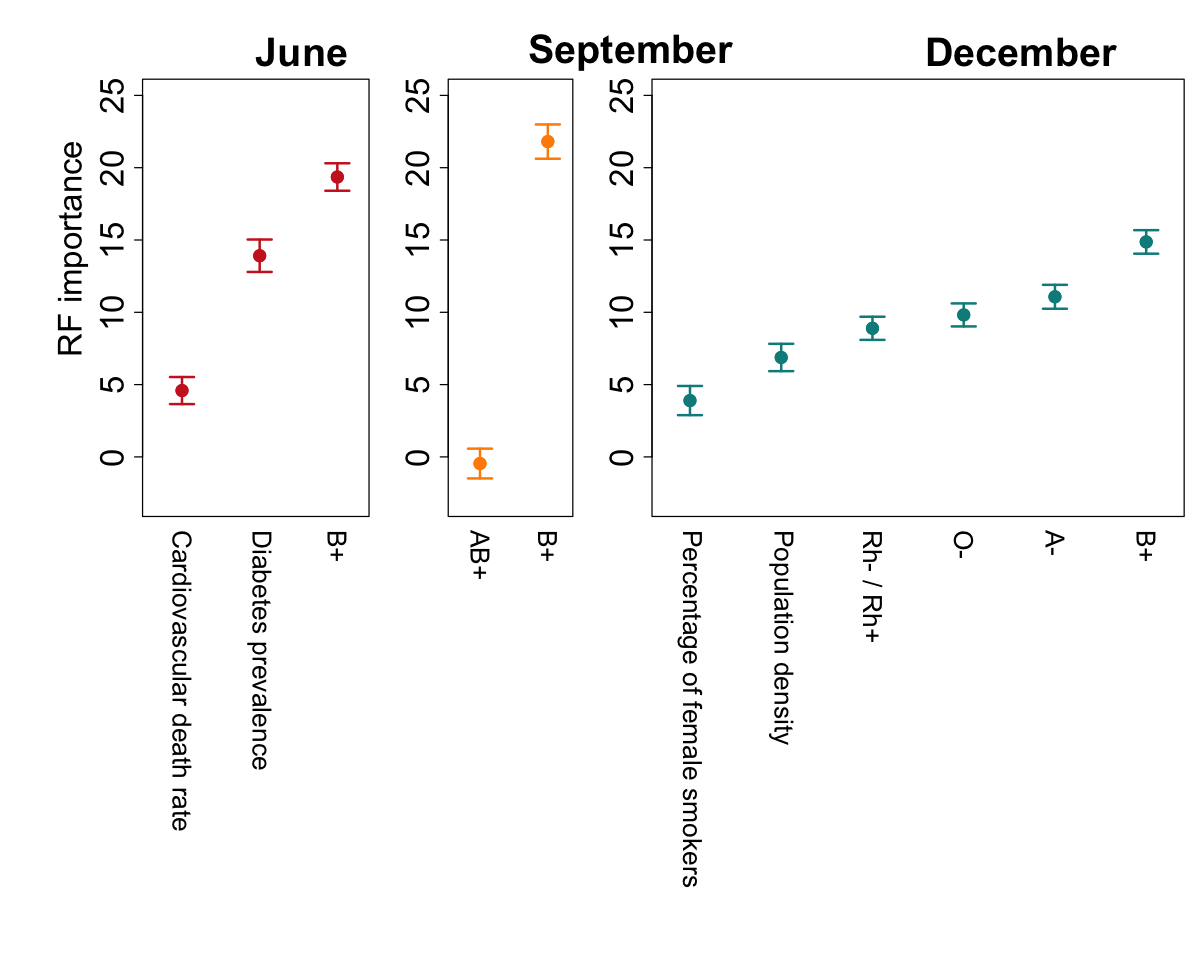

In [13]:
#FIGURE 5
#setEPS()
#postscript("RF100.eps", width = 15, height = 10)

options(repr.plot.width = 10, repr.plot.height = 8)
layout(matrix(c(1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3), 1, 11, byrow = TRUE))
par(mar = c(28, 4, 5, 1), oma=c(0, 5, 0, 0))

#JUNE
importanceMEAN06RF <- rowMeans(importance06RF)
importanceSD06RF <- cbind(apply(importance06RF, 1, sd, na.rm = TRUE))

y <- rowMeans(importance06RF)
o <- order(y, decreasing = FALSE)

x <- 1:length(y)
#rownames(importance06RF)[o]
names <- c('Cardiovascular death rate', 'Diabetes prevalence', 'B+')
ymin=(y-importanceSD06RF)[o]
ymax=(y+importanceSD06RF)[o]
plot(x, y[o], xlim = c(0.6, 3.3), pch = 19, ylim = c(-3, 25), xlab = "", ylab = "", xaxt = "n", 
     cex.lab = 2.5, cex.axis = 2.5, cex = 2, col = "firebrick3")
text(x = -0.4, y = -5, "RF importance", srt = 90, xpd = NA, cex = 2.5, adj = -0.8)
#rect(par("usr")[1],par("usr")[3],par("usr")[2],par("usr")[4], col="lavenderblush", add=TRUE)
points(x, y[o], type = "p", xlim = c(0.8, 3.2), ylim = c(-3, 25), pch = 19, col = "firebrick3", add = TRUE, cex = 2)
arrows(x, ymin, x, ymax, code = 3, angle = 90, length = 0.1, col = "firebrick3", lwd = 2)
text(x = x, y = -5, labels = names, srt = -90, xpd = NA, cex = 2, adj = 0)
text(x =1, y = 28, "June", srt = 0, xpd = NA, cex = 3, adj = -0.8, font = 2)

#SEPTEMBER
importanceMEAN09RF <- rowMeans(importance09RF)
importanceSD09RF <- cbind(apply(importance09RF, 1, sd, na.rm = TRUE))

y <- rowMeans(importance09RF)
o <- order(y, decreasing = FALSE)

x <- 1:length(y)
#rownames(importance09RF)[o]
names <- c('AB+', 'B+')
ymin=(y - importanceSD09RF)[o]
ymax=(y + importanceSD09RF)[o]
plot(x, y[o], xlim = c(0.6, 2.3), ylim = c(-3, 25), pch = 19, xlab = "", ylab = "", xaxt = "n", 
     cex.lab = 3, cex.axis = 2.5, cex = 2, col = "darkorange")
#rect(par("usr")[1],par("usr")[3],par("usr")[2],par("usr")[4], col="lightyellow", add=TRUE)
points(x, y[o], type = "p", xlim = c(0.8, 2.2), ylim = c(-3, 25), pch = 19, col = "darkorange", 
       add = TRUE, cex = 2)
#plot(x, y[o], xlim=c(0.8,2.2), ylim=c(-3,25), pch=19, xlab="", ylab="", xaxt="n", cex.lab=3, cex.axis=2.5, cex=2, col="darkorange", add=TRUE)
arrows(x, ymin, x, ymax, code = 3, angle = 90, length = 0.1, col = "darkorange", lwd = 2, add = TRUE)
text(x = x, y = -5, labels = names, srt = -90, xpd = NA, cex = 2, adj = 0)
text(x = -0.7, y = 28, "September", srt = 0, xpd = NA, cex = 3, adj = -0.8, font = 2)

#DECEMBER
importanceMEAN12RF <- rowMeans(importance12RF)
importanceSD12RF <- cbind(apply(importance12RF, 1, sd, na.rm = TRUE))

y <- rowMeans(importance12RF)
o <- order(y, decreasing = FALSE)

x <- 1:length(y)
#rownames(importance12RF)[o]
names <- c("Percentage of female smokers", "Population density", "Rh- / Rh+", "O-", "A-", "B+")
ymin=(y-importanceSD12RF)[o]
ymax=(y+importanceSD12RF)[o]
plot(x, y[o], xlim = c(0.8, 6.2), ylim = c(-3, 25), pch = 19, xlab = "", ylab = "", xaxt = "n", 
     cex.axis = 2.5, cex.lab = 2, cex = 2, col = "darkcyan")
#rect(par("usr")[1],par("usr")[3],par("usr")[2],par("usr")[4], col="lightcyan", add=TRUE)
points(x, y[o], type="p", xlim = c(0.8,6.2), ylim = c(-3, 25), pch = 19, col = "darkcyan", add = TRUE, cex = 2)
arrows(x, ymin, x, ymax, code = 3, angle = 90, length = 0.1, col = "darkcyan", lwd = 2)
text(x = x, y = -5, labels = names, srt = -90, xpd = NA, cex = 2, adj = 0)
text(x = 1.9, y = 28, "December", srt = 0, xpd = NA, cex = 3, adj = -0.8, font = 2)
#dev.off()

In [14]:
#TABLE IV, ROW 1 (June)
set.seed(123) 
train.control <- trainControl(method = "cv", number = 5)
model <- train(TDPM_06 ~ Bplus + diabetes_prevalence, data = data, method = "rf", trControl = train.control)
model$results

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



,mtry,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,134.7415,0.4732908,84.74444,10.18733,0.1316578,10.83558


In [15]:
#TABLE IV, ROW 2 (September)
model <- train(TDPM_09 ~ Bplus + Abplus, data = data, method = "rf", trControl = train.control)
model$results

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



,mtry,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,191.5624,0.2537432,129.1346,36.88603,0.1870009,24.15606


In [16]:
#TABLE IV, ROW 3 (December)
model <- train(TDPM_12 ~ density_pop + female_smokers + Bplus + Aminus + Ominus + Rhminus_Rhplus, 
               data = data, method = "rf", trControl = train.control)
model$results

,mtry,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,309.5393,0.3401138,239.4937,51.39460,0.07109639,37.96532
2,4,311.8393,0.3347726,241.3728,48.19554,0.03900133,38.79969
3,6,316.1979,0.3247943,245.4076,50.58698,0.04888669,42.21285


In [17]:
#TABLE V ROW 1 (June)
set.seed(121) 
borutaVars06 = c("Bplus", "diabetes_prevalence", "cardiovasc_death_rate") 
formula.lmboruta06 <- formula(paste("TDPM_06~", paste(paste("scale(", borutaVars06,")"), collapse="+")))

train.control <- trainControl(method = "cv", number = 5) 
model <- train(formula.lmboruta06, data = data, method = "lm", trControl = train.control) 
model$results

,intercept,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TRUE,138.0933,0.3152842,104.6573,49.16024,0.09757864,35.44824


In [18]:
#TABLE V ROW 2 (September)
set.seed(123)
borutaVars09 = c("Bplus", "Abplus")
formula.lmboruta09 <- formula(paste("TDPM_09~", paste(paste("scale(", borutaVars09,")"), collapse = "+")))

train.control <- trainControl(method = "cv", number = 5)
model <- train(formula.lmboruta09, data = data, method = "lm", trControl = train.control)
model$results

,intercept,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TRUE,184.2288,0.3144658,148.5688,36.18771,0.152197,33.74352


In [19]:
#TABLE V ROW 3 (December)
set.seed(123)
borutaVars12 = c("Bplus", "Ominus", "Aminus", "Rhminus_Rhplus", "female_smokers", "density_pop")
formula.lmboruta12 <- formula(paste("TDPM_12~", paste(paste("scale(", borutaVars12,")"), collapse = "+")))

train.control <- trainControl(method = "cv", number = 5)
model <- train(formula.lmboruta12, data = data, method = "lm", trControl = train.control)
model$results

,intercept,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TRUE,328.9377,0.2883999,260.1713,63.65875,0.167054,44.36717


In [20]:
#Repeated CV 
set.seed(123) 
train.control <- trainControl(method = "repeatedcv", number = 5, repeats = 100)
model <- train(TDPM_06 ~ Bplus + diabetes_prevalence, data = data, method = "rf", trControl = train.control)
resample_rf_06 = model$resample
set.seed(123) 
model <- train(TDPM_09 ~ Bplus + Abplus, data = data, method = "rf", trControl = train.control)
resample_rf_09 = model$resample
set.seed(123) 
model <- train(TDPM_12 ~ density_pop + female_smokers + Bplus + Aminus + Ominus + Rhminus_Rhplus, 
               data = data, method = "rf", trControl = train.control)
resample_rf_12 = model$resample
borutaVars06 = c("Bplus", "diabetes_prevalence", "cardiovasc_death_rate") 
formula.lmboruta06 <- formula(paste("TDPM_06~", paste(paste("scale(", borutaVars06,")"), collapse="+")))
set.seed(123) 
model <- train(formula.lmboruta06, data = data, method = "lm", trControl = train.control) 
resample_lm_06 = model$resample
set.seed(123)
borutaVars09 = c("Bplus", "Abplus")
formula.lmboruta09 <- formula(paste("TDPM_09~", paste(paste("scale(", borutaVars09,")"), collapse = "+")))
model <- train(formula.lmboruta09, data = data, method = "lm", trControl = train.control)
resample_lm_09 = model$resample
set.seed(123)
borutaVars12 = c("Bplus", "Ominus", "Aminus", "Rhminus_Rhplus", "female_smokers", "density_pop")
formula.lmboruta12 <- formula(paste("TDPM_12~", paste(paste("scale(", borutaVars12,")"), collapse = "+")))
model <- train(formula.lmboruta12, data = data, method = "lm", trControl = train.control)
resample_lm_12 = model$resample

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



In [29]:
data_06 = data.frame("RMSE" = c(resample_rf_06$RMSE, resample_lm_06$RMSE), "Method" = c(rep("RF", 500), rep("lm", 500)))
kruskal.test(RMSE ~ Method, data = data_06)

data_09 = data.frame("RMSE" = c(resample_rf_09$RMSE, resample_lm_09$RMSE), "Method" = c(rep("RF", 500), rep("lm", 500)))
kruskal.test(RMSE ~ Method, data = data_09)

data_12 = data.frame("RMSE" = c(resample_rf_12$RMSE, resample_lm_12$RMSE), "Method" = c(rep("RF", 500), rep("lm", 500)))
kruskal.test(RMSE ~ Method, data = data_12)

data_06 = data.frame("R2" = c(resample_rf_06$Rsquared, resample_lm_06$Rsquared), "Method" = c(rep("RF", 500), rep("lm", 500)))
kruskal.test(R2 ~ Method, data = data_06)

data_09 = data.frame("R2" = c(resample_rf_09$Rsquared, resample_lm_09$Rsquared), "Method" = c(rep("RF", 500), rep("lm", 500)))
kruskal.test(R2 ~ Method, data = data_09)

data_12 = data.frame("R2" = c(resample_rf_12$Rsquared, resample_lm_12$Rsquared), "Method" = c(rep("RF", 500), rep("lm", 500)))
kruskal.test(R2 ~ Method, data = data_12)

data_06 = data.frame("MAE" = c(resample_rf_06$MAE, resample_lm_06$MAE), "Method" = c(rep("RF", 500), rep("lm", 500)))
kruskal.test(MAE ~ Method, data = data_06)

data_09 = data.frame("MAE" = c(resample_rf_09$MAE, resample_lm_09$MAE), "Method" = c(rep("RF", 500), rep("lm", 500)))
kruskal.test(MAE ~ Method, data = data_09)

data_12 = data.frame("MAE" = c(resample_rf_12$MAE, resample_lm_12$MAE), "Method" = c(rep("RF", 500), rep("lm", 500)))
kruskal.test(MAE ~ Method, data = data_12)


	Kruskal-Wallis rank sum test

data:  RMSE by Method
Kruskal-Wallis chi-squared = 8.4631, df = 1, p-value = 0.003624



	Kruskal-Wallis rank sum test

data:  RMSE by Method
Kruskal-Wallis chi-squared = 0.64833, df = 1, p-value = 0.4207



	Kruskal-Wallis rank sum test

data:  RMSE by Method
Kruskal-Wallis chi-squared = 29.464, df = 1, p-value = 5.697e-08



	Kruskal-Wallis rank sum test

data:  R2 by Method
Kruskal-Wallis chi-squared = 136.6, df = 1, p-value < 2.2e-16



	Kruskal-Wallis rank sum test

data:  R2 by Method
Kruskal-Wallis chi-squared = 14.214, df = 1, p-value = 0.0001631



	Kruskal-Wallis rank sum test

data:  R2 by Method
Kruskal-Wallis chi-squared = 37.785, df = 1, p-value = 7.897e-10



	Kruskal-Wallis rank sum test

data:  MAE by Method
Kruskal-Wallis chi-squared = 183.5, df = 1, p-value < 2.2e-16



	Kruskal-Wallis rank sum test

data:  MAE by Method
Kruskal-Wallis chi-squared = 101.39, df = 1, p-value < 2.2e-16



	Kruskal-Wallis rank sum test

data:  MAE by Method
Kruskal-Wallis chi-squared = 69.747, df = 1, p-value < 2.2e-16


Loading required package: sp

### Welcome to rworldmap ###

For a short introduction type : 	 vignette('rworldmap')


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




76 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
167 codes from the map weren't represented in your data


You asked for 7 categories, 8 were used due to pretty() classification

Warning message in rwmGetColours(colourPalette, numColours):
“100 colours specified and 8 required, using interpolation to calculate colours”


76 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
167 codes from the map weren't represented in your data


You asked for 7 categories, 5 were used due to pretty() classification

Warning message in rwmGetColours(colourPalette, numColours):
“100 colours specified and 5 required, using interpolation to calculate colours”


76 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
167 codes from the map weren't represented in your data


You asked for 7 categories, 8 were used due to pretty() classification

Warning message in rwmGetColours(colourPalette, numColours):
“100 colours specified and 8 required, using interpolation to calculate colours”


76 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
167 codes from the map weren't represented in your data


You asked for 7 categories, 6 were used due to pretty() classification

Warning message in rwmGetColours(colourPalette, numColours):
“100 colours specified and 6 required, using interpolation to calculate colours”


76 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
167 codes from the map weren't represented in your data


You asked for 7 categories, 8 were used due to pretty() classification

Warning message in rwmGetColours(colourPalette, numColours):
“100 colours specified and 8 required, using interpolation to calculate colours”


76 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
167 codes from the map weren't represented in your data


Warning message in rwmGetColours(colourPalette, numColours):
“100 colours specified and 7 required, using interpolation to calculate colours”


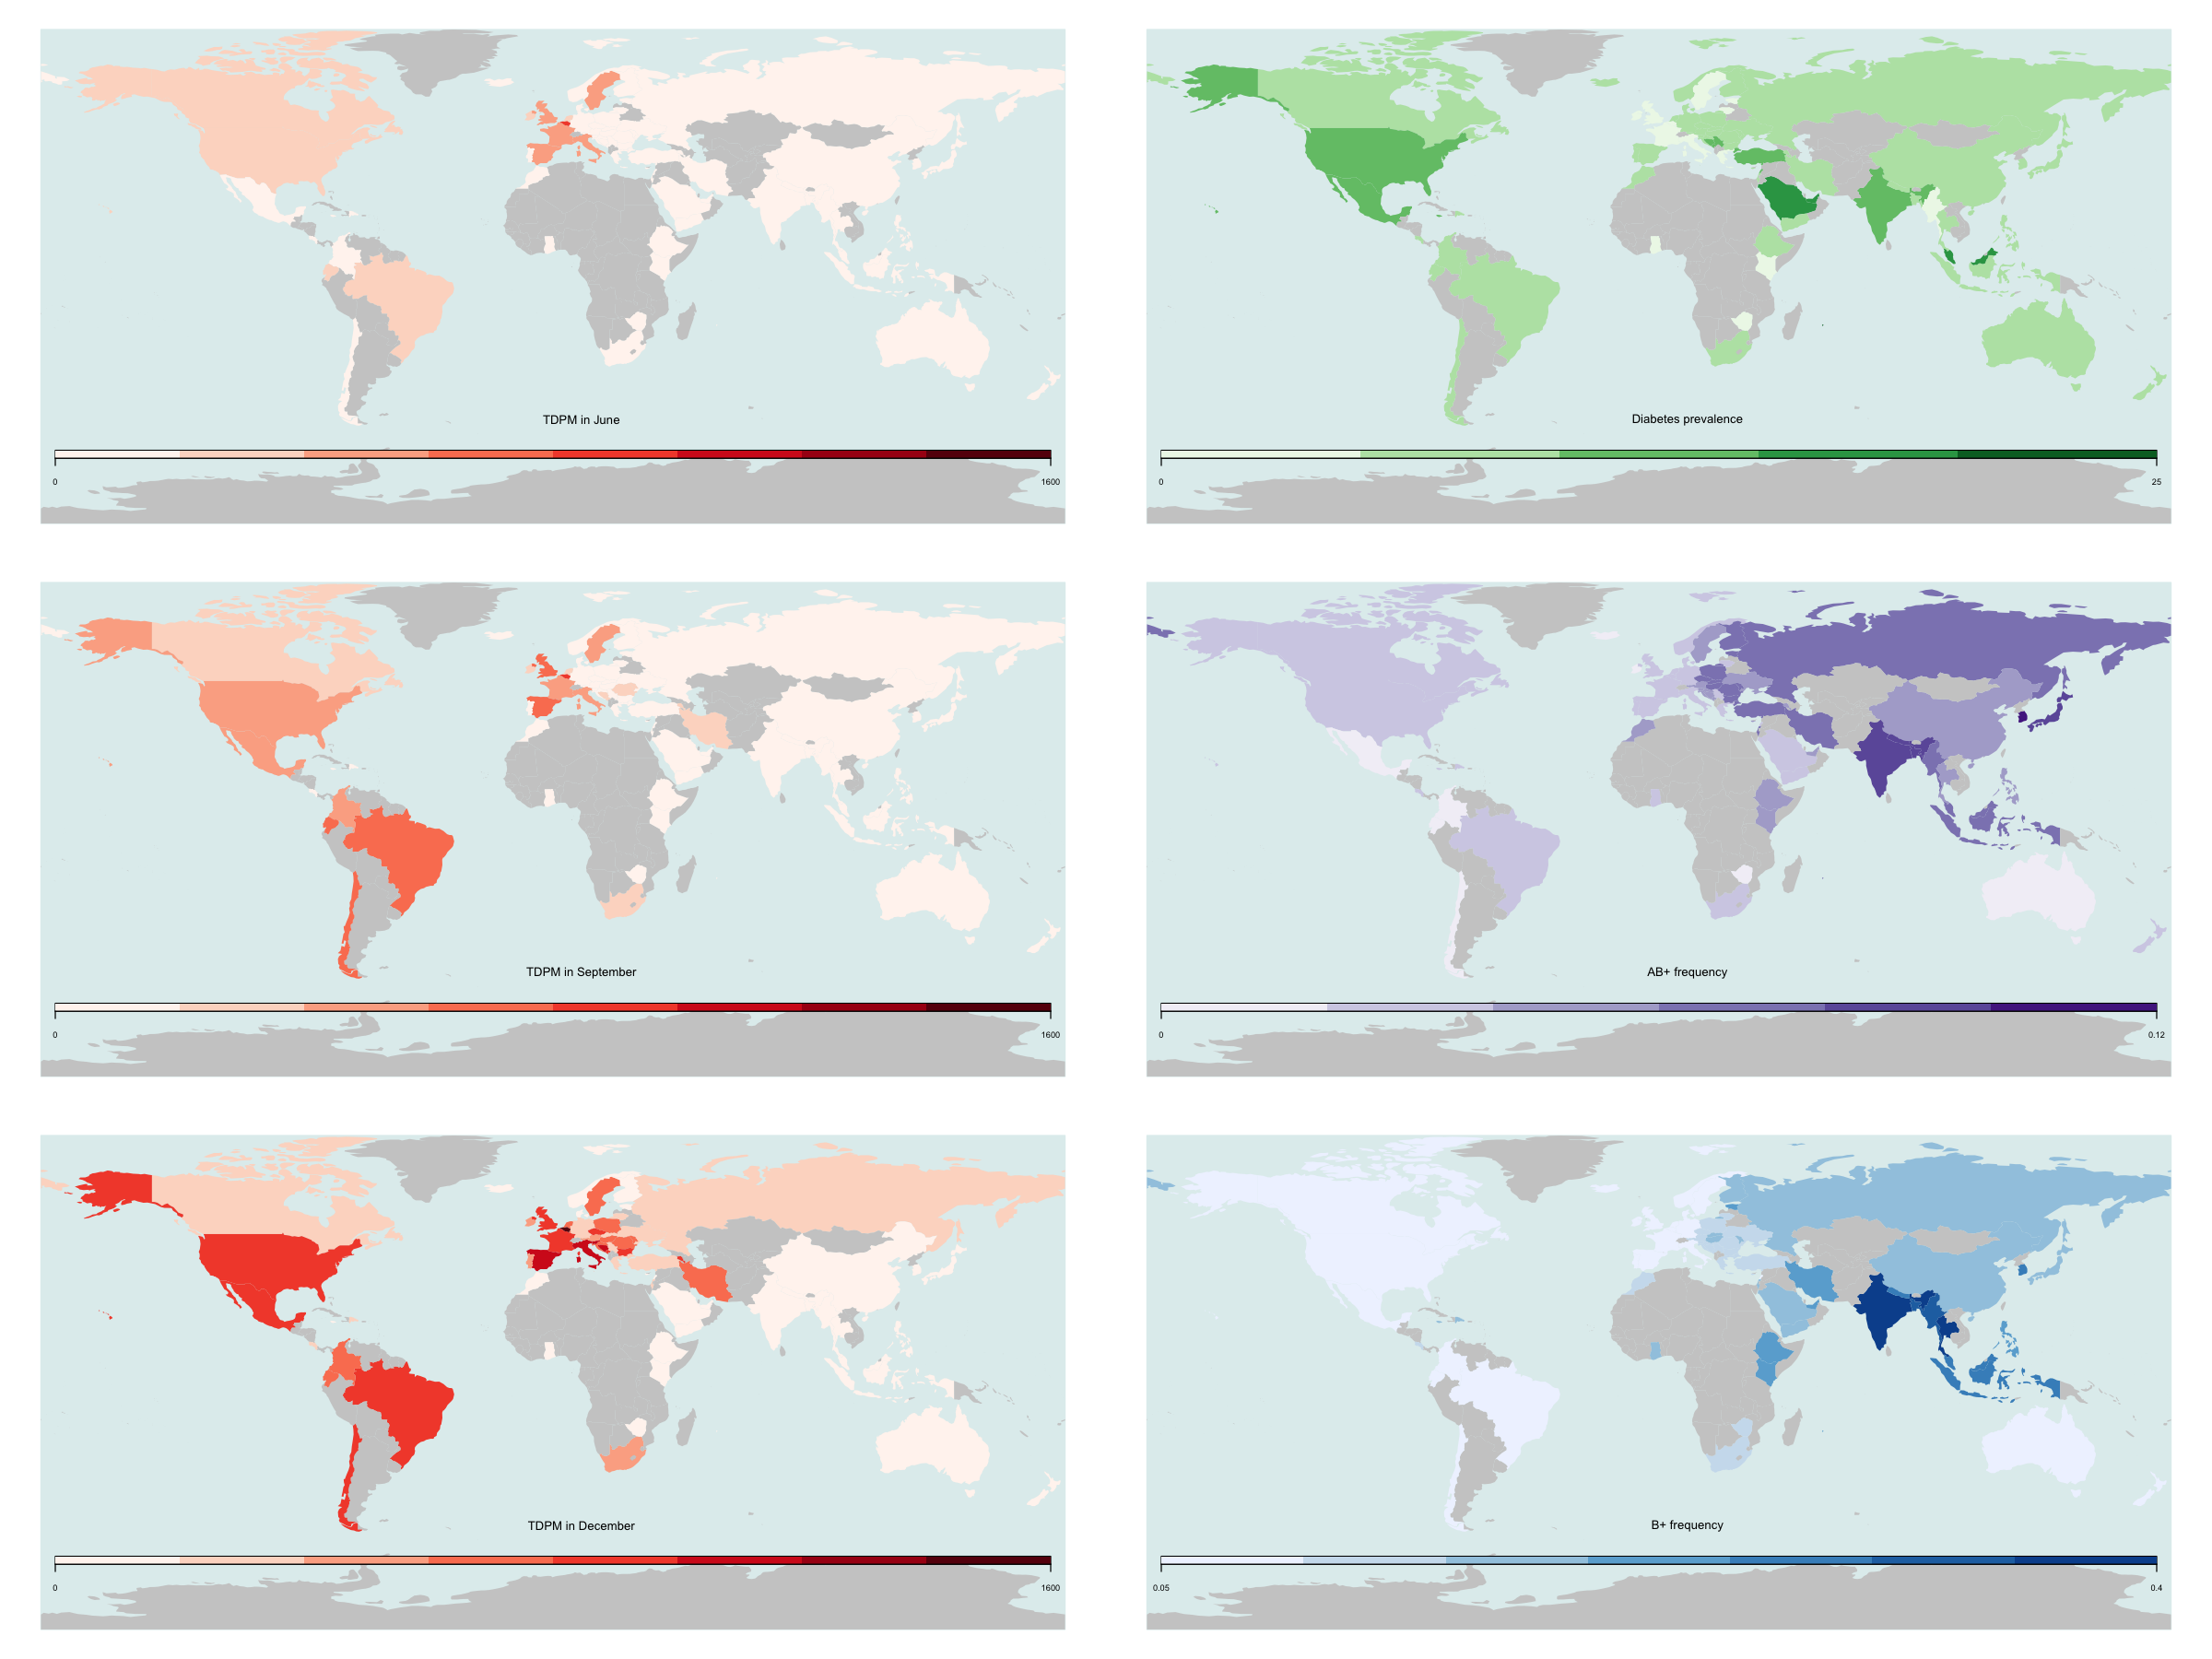

In [22]:
#FIG 3
library(rworldmap)
library(DT)
library(RColorBrewer)
library(scales)

#add a fake very small country to normalize TDPM scale on the map
data[76,] <- data[75,]
data[75, "location"] <- "Vatican City"
data[75, "iso_code"] <- "VAT"
data[75, "TDPM_12"] <- 1600
data[75, "TDPM_06"] <- 1600
data[75, "TDPM_09"] <- 1600

#setEPS()
#postscript("Maps.eps")
options(repr.plot.width = 20, repr.plot.height = 15)
par(mfrow = c(3, 2), oma = c(0, 0, 0, 0), mar = c(0, 0, 0, 0), pty = "m")

worldmap <- getMap(resolution = "coarse")
palette <- colorRampPalette(brewer.pal(n = 9, name = 'Greens'))(100)

#TDPM_06
countriesvalues <- data.frame(country = data$iso_code, values = data$TDPM_06)
valuesMap <- joinCountryData2Map(countriesvalues, joinCode = "ISO3", nameJoinColumn = "country")
# def. map parameters, e.g. def. colors
mapParams <- mapCountryData(valuesMap, 
                            nameColumnToPlot = "values",
                            oceanCol = "azure2",
                            catMethod = "pretty" ,
                            missingCountryCol = gray(.8),
                            colourPalette = colorRampPalette(brewer.pal(n = 9, name = 'Reds'))(100),
                            addLegend = F,
                            mapTitle = "",
                            border = NA)
# add legend and display map
do.call(addMapLegend, c(mapParams, 
                        #mgp=c(0,0,0),
                        legendWidth = 0.5, 
                        legendMar = 6, 
                        legendLabels = "limits", 
                        labelFontSize = 0.7))
text(10, -70, cex = 1, labels = "TDPM in June")

countriesvalues <- data.frame(country = data$iso_code, values = data$diabetes_prevalence)
valuesMap <- joinCountryData2Map(countriesvalues, joinCode = "ISO3", nameJoinColumn = "country")
# def. map parameters, e.g. def. colors
mapParams <- mapCountryData(valuesMap, 
                            nameColumnToPlot = "values",
                            oceanCol = "azure2",
                            catMethod = "pretty" ,
                            missingCountryCol = gray(.8),
                            colourPalette = colorRampPalette(brewer_pal(palette = "Greens",direction = 1)(5))(100),
                            addLegend = F,
                            mapTitle = "",
                            border = NA)
# add legend and display map
do.call(addMapLegend, c(mapParams, 
                        legendWidth = 0.5, 
                        legendMar = 6, 
                        legendLabels = "limits", 
                        labelFontSize = 0.7))
text(10, -70, cex = 1, labels = "Diabetes prevalence")

countriesvalues <- data.frame(country = data$iso_code, values = data$TDPM_09)
valuesMap <- joinCountryData2Map(countriesvalues, joinCode = "ISO3", nameJoinColumn = "country")
# def. map parameters, e.g. def. colors
mapParams <- mapCountryData(valuesMap, 
                            nameColumnToPlot = "values",
                            oceanCol = "azure2",
                            catMethod = "pretty" ,
                            missingCountryCol = gray(.8),
                            colourPalette = colorRampPalette(brewer.pal(n = 9, name = 'Reds'))(100),                            
                            addLegend = F,
                            mapTitle = "",
                            border = NA)
# add legend and display map
do.call(addMapLegend, c(mapParams, 
                        legendWidth = 0.5, 
                        legendMar = 6, 
                        legendLabels = "limits", 
                        labelFontSize = 0.7))
text(10, -70, cex = 1, labels = "TDPM in September")

countriesvalues <- data.frame(country = data$iso_code, values = data$Abplus)
valuesMap <- joinCountryData2Map(countriesvalues, joinCode = "ISO3", nameJoinColumn = "country")
# def. map parameters, e.g. def. colors
mapParams <- mapCountryData(valuesMap, 
                            nameColumnToPlot = "values",
                            oceanCol = "azure2",
                            catMethod = "pretty" ,
                            missingCountryCol = gray(.8),
                            colourPalette = colorRampPalette(brewer_pal(palette = "Purples", direction = 1)(5))(100),
                            addLegend = F,
                            mapTitle = "",
                            border = NA)
# add legend and display map
do.call(addMapLegend, c(mapParams, 
                        legendWidth = 0.5, 
                        legendMar = 6, 
                        legendLabels = "limits", 
                        labelFontSize = 0.7))
text(10, -70, cex = 1, labels = "AB+ frequency")

countriesvalues <- data.frame(country=data$iso_code, values = data$TDPM_12)
valuesMap <- joinCountryData2Map(countriesvalues, joinCode = "ISO3", nameJoinColumn = "country")
# def. map parameters, e.g. def. colors
mapParams <- mapCountryData(valuesMap, 
                            nameColumnToPlot = "values",
                            oceanCol = "azure2",
                            catMethod = "pretty" ,
                            missingCountryCol = gray(.8),
                            colourPalette = colorRampPalette(brewer.pal(n = 9, name = 'Reds'))(100),                            
                            addLegend = F,
                            mapTitle = "",
                            border = NA)
# add legend and display map
do.call(addMapLegend, c(mapParams, 
                        legendWidth = 0.5, 
                        legendMar = 6, 
                        legendLabels = "limits", 
                        labelFontSize = 0.7))
text(10, -70, cex = 1, labels = "TDPM in December")

countriesvalues <- data.frame(country = data$iso_code, values = data$Bplus)
valuesMap <- joinCountryData2Map(countriesvalues, joinCode = "ISO3", nameJoinColumn = "country")

# def. map parameters, e.g. def. colors
mapParams <- mapCountryData(valuesMap, 
                            nameColumnToPlot = "values",
                            oceanCol = "azure2",
                            catMethod = "pretty" ,
                            missingCountryCol = gray(.8),
                            colourPalette = colorRampPalette(brewer_pal(palette = "Blues", direction = 1)(5))(100),
                            addLegend = F,
                            mapTitle = "",
                            border = NA)
# add legend and display map
do.call(addMapLegend, c(mapParams, 
                        legendWidth = 0.5, 
                        legendMar = 6, 
                        legendLabels = "limits", 
                        labelFontSize = 0.7))
text(10, -70, cex = 1, labels = "B+ frequency")
#dev.off()

In [23]:
sessionInfo(package = NULL)

R version 4.0.5 (2021-03-31)
Platform: x86_64-apple-darwin20.3.0 (64-bit)
Running under: macOS Big Sur 11.6

Matrix products: default
BLAS:   /usr/local/Cellar/openblas/0.3.13/lib/libopenblasp-r0.3.13.dylib
LAPACK: /usr/local/Cellar/r/4.0.5/lib/R/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.1.1        RColorBrewer_1.1-2  DT_0.19            
 [4] rworldmap_1.3-6     sp_1.4-5            caret_6.0-90       
 [7] lattice_0.20-45     forcats_0.5.1       stringr_1.4.0      
[10] dplyr_1.0.7         purrr_0.3.4         readr_2.0.2        
[13] tidyr_1.1.4         tibble_3.1.5        ggplot2_3.3.5      
[16] tidyverse_1.3.1     Metrics_0.1.4       Boruta_7.0.0       
[19] randomForest_4.6-14 corrplot_0.90       readxl_1.3.1       

loaded via a namespace (and not attached):
 [1] colorspace_2.0-2     ellipsis_0.3.2       class_7.3-19        
 [4] IRdisp